Team CoronaBoost
477631,  
Øyvind Samuelsen, Mikkel Nygard
Challenge: 3

In [139]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor

In [140]:
# Load train/test data
train = pd.read_csv('data/challenge3_train.csv', index_col='id')
test = pd.read_csv('data/challenge3_test.csv', index_col='id')

In [141]:
# Helper lists for column types
features_bin = ['f0', 'f26'] # binary
features_nom_low = ['f5'] # nominal low cardinality (<=3)
features_nom_high = ['f12', 'f28'] # >= 26
features_ord_low = ['f1', 'f2', 'f3', 'f6', 'f9', 'f11', 'f13', 'f15', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f27', 'f29']
features_ord_num = ['f1', 'f2', 'f3', 'f6', 'f9', 'f11', 'f13', 'f17', 'f18', 'f19', 'f21', 'f23', 'f24', 'f25', 'f27', 'f29']
features_ord_high = ['f4', 'f10', 'f14']
features_real = ['f7', 'f8', 'f16', 'f22', 'f30'] # real numbers.

features_ord_alph = ['f15', 'f20']
ohe_columns = features_ord_alph + features_nom_low

## Data cleaning
Based on exploration we have done these steps for data cleaning. After each step we tested to see if the accuracy in a basic XGB model improved, to decide if we would include it or not

In [142]:
# Fix 0 value noise, change to most common value in column. 
impute_0_columns = ['f3', 'f18', 'f21']

for column in impute_0_columns:
    train.loc[train[column] == 0, column] = train[column].mode() # mode() finds most common value
    test.loc[test[column] == 0, column] = test[column].mode()

# remove -1 from 'month' column f11
train.loc[train['f11'] == -1, 'f11'] = train['f11'].mode()
test.loc[test['f11'] == -1, 'f11'] = test['f11'].mode()

## Feature engineering
Similar to data cleaning, we have tested each step to see if it improves

In [143]:
# improves
train['f6_f25'] = train['f6'].fillna(1)**2*train['f25'].fillna(1)**2
test['f6_f25'] = test['f6'].fillna(1)**2*test['f25'].fillna(1)**2

In [144]:
# We hypothesise column f11 describes months, from 0-11
# so add cyclical feature
def cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df
train = cyc_enc(train, 'f11', 11)
test = cyc_enc(test, 'f11', 11)

In [145]:
# For columns with dtype 'object' we need to represent them as numeric.
# One hot encoding gave us best result, compared to label encoding and target encoding.
train = pd.get_dummies(train, columns=ohe_columns + features_nom_high)
test = pd.get_dummies(test, columns=ohe_columns + features_nom_high)

## Modeling
We use XGBoost, CatBoos

In [158]:
# split train set into a train and test set
X = train.drop(['target'], axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
{'colsample_bytree': 0.7541691347538767, 'eval_metric': 'auc', 'gamma': 0.4511313995198146, 'learning_rate': 0.03432377692457561, 'max_depth': 9, 'min_child_weight': 4.0, 'reg_alpha': 0.33753466341724986, 'reg_lambda': 0.3322614438833425, 'subsample': 0.8}

{'colsample_bytree': 0.7541691347538767,
 'gamma': 0.4511313995198146,
 'learning_rate': 0.03432377692457561,
 'max_depth': 6,
 'min_child_weight': 4.0,
 'reg_alpha': 0.33753466341724986,
 'reg_lambda': 0.3322614438833425,
 'subsample': 3}

In [161]:
%%time

xgbmodel = XGBRegressor(**{'colsample_bytree': 0.7541691347538767, 
                           'eval_metric': 'auc', 
                           'gamma': 0.4511313995198146, 
                           'learning_rate': 0.03432377692457561, 
                           'max_depth': 9, 'min_child_weight': 4.0, 'reg_alpha': 0.33753466341724986, 'reg_lambda': 0.3322614438833425, 'subsample': 0.8}

{'colsample_bytree': 0.7541691347538767,
 'gamma': 0.4511313995198146,
 'learning_rate': 0.03432377692457561,
 'max_depth': 6,
 'min_child_weight': 4.0,
 'reg_alpha': 0.33753466341724986,
 'reg_lambda': 0.3322614438833425,
 'subsample': 3})

xgbmodel.fit(X_train, y_train, verbose=False)
predictions = xgbmodel.predict(X_test)
#calculate score
base_score = roc_auc_score(y_test, predictions)

0.9078414030374676
CPU times: user 1min 51s, sys: 763 ms, total: 1min 52s
Wall time: 38.3 s


In [146]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
from hyperopt import fmin, hp, tpe
import gc
import time

RANDOM_STATE = 42 # 

# Use Hyperopt to optimize xgboost parameters.
def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count=1
    kf = KFold(n_splits=FOLDS, shuffle=True) # random_state=params['random_state']

    y_preds = np.zeros(test.shape[0])
    score_mean = 0
    scal_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    for tr_idx, val_idx in kf.split(X_train, y_train):
        
        X_tr, X_val = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf = XGBRegressor(
            n_estimators=300, 
            scale_pos_weight=scal_pos_weight,
            **params
        )
        clf.fit(X_tr, y_tr),

        predictions = clf.predict(X_val)
        #calculate score
        score = roc_auc_score(y_val, predictions)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_val, y_tr, y_val, clf, score
    
    return -(score_mean / FOLDS)

# https://xgboost.readthedocs.io/en/latest/parameter.html
space = {
    #'random_state': RANDOM_STATE,
    
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [.5, 0.6, 0.7, .8]),
    
    'min_child_weight' : hp.quniform('min_child_weight', 1, 5, 1),
    
    'eval_metric': 'auc',

}

In [147]:
%%time
# We use hyperpot to find the best hyperparameters
# Note: takes forever
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=40,
           )
"""
**{'colsample_bytree': 0.7048862950970731,
 'gamma': 0.6870786593228237,
 'learning_rate': 0.043037814961976235,
 'max_depth': 8,
 'reg_alpha': 0.12849120484354531,
 'reg_lambda': 0.21891264474184496,
}"""

                                                      
############## New Run ################
params = {'colsample_bytree': 0.3396229146980822, 'eval_metric': 'auc', 'gamma': 0.1508557958741393, 'learning_rate': 0.05899090792719509, 'max_depth': 4, 'min_child_weight': 3.0, 'reg_alpha': 0.10874985371929055, 'reg_lambda': 0.11138007760898921, 'subsample': 0.6}
1 CV - score: 0.9045                                  
2 CV - score: 0.9009                                  
3 CV - score: 0.9085                                  
4 CV - score: 0.9028                                  
5 CV - score: 0.9049                                  
Total Time Run: 3.09                                  
Mean ROC_AUC: 0.9042987094912338                      
                                                                                    
############## New Run ################
params = {'colsample_bytree': 0.3789990035682237, 'eval_metric': 'auc', 'gamma': 0.5604753425208716, 'learning_rate': 0.12428827

"\n**{'colsample_bytree': 0.7048862950970731,\n 'gamma': 0.6870786593228237,\n 'learning_rate': 0.043037814961976235,\n 'max_depth': 8,\n 'reg_alpha': 0.12849120484354531,\n 'reg_lambda': 0.21891264474184496,\n}"

In [148]:
best

{'colsample_bytree': 0.7541691347538767,
 'gamma': 0.4511313995198146,
 'learning_rate': 0.03432377692457561,
 'max_depth': 6,
 'min_child_weight': 4.0,
 'reg_alpha': 0.33753466341724986,
 'reg_lambda': 0.3322614438833425,
 'subsample': 3}

In [ ]:
params = {'colsample_bytree': 0.7541691347538767, 'eval_metric': 'auc', 'gamma': 0.4511313995198146, 'learning_rate': 0.03432377692457561, 'max_depth': 9, 'min_child_weight': 4.0, 'reg_alpha': 0.33753466341724986, 'reg_lambda': 0.3322614438833425, 'subsample': 0.8}

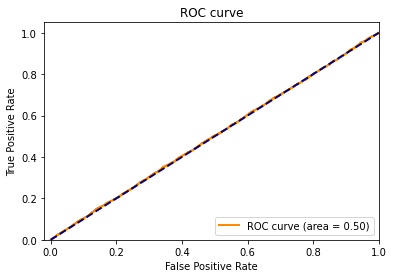

In [63]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def print_roc_curve(test_y, predictions):
    fpr, tpr, _ = roc_curve(test_y, predictions)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

print_roc_curve(y_test, predictions)

In [64]:
%%time 
# now lets try tuning xgboost by letting it stop learning when the validation score stops improving, 
# and letting it cycle through the learning process until it does so

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# fit new df to model
my_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
# generate predictions
predictions = my_model.predict(X_test)
#calculate score
tuned_score = roc_auc_score(y_test, predictions)
print(tuned_score)

0.9108178905257609
CPU times: user 3min 46s, sys: 942 ms, total: 3min 47s
Wall time: 1min 19s


## Training final model, predict test set and delivery csv

In [89]:
test

,id,f0,f1,f2,f3,f4,f6,f7,f8,f9,...,f28_wa,f28_xB,f28_xF,f28_xG,f28_yE,f28_yK,f28_zc,f28_ze,f28_zf,f28_zp
0,50000,NaN,5.0,5.0,3.0,3220.0,4.0,-11.5573,14.3455,4.0,...,0,0,0,0,0,0,0,0,0,0
1,50001,NaN,4.0,4.0,3.0,NaN,3.0,-4.5487,14.3633,0.0,...,0,0,0,0,0,0,0,0,0,0
2,50002,0.0,NaN,NaN,4.0,1916.0,2.0,NaN,14.1969,1.0,...,0,0,0,0,0,0,0,0,0,0
3,50003,NaN,2.0,2.0,1.0,334.0,NaN,-4.9250,14.3287,0.0,...,0,0,0,0,0,0,0,0,0,0
4,50004,NaN,4.0,4.0,3.0,828.0,4.0,-11.8335,13.9793,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,99995,NaN,NaN,2.0,5.0,544.0,5.0,-6.8409,14.3688,0.0,...,0,0,0,0,0,0,0,0,0,0
49996,99996,NaN,NaN,0.0,1.0,NaN,3.0,-5.4951,14.4914,3.0,...,0,0,0,0,0,0,0,0,0,0
49997,99997,0.0,3.0,4.0,4.0,1182.0,3.0,NaN,14.0421,3.0,...,0,0,0,0,0,0,0,0,0,0
49998,99998,NaN,3.0,5.0,5.0,2551.0,NaN,-10.1088,14.3610,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time

xgbmodel = XGBRegressor(**{'colsample_bytree': 0.7048862950970731,
 'gamma': 0.6870786593228237,
 'learning_rate': 0.043037814961976235,
 'max_depth': 8,
 'reg_alpha': 0.12849120484354531,
 'reg_lambda': 0.21891264474184496,
})

xgbmodel.fit(X, y, verbose=False)
predictions = xgbmodel.predict(test)
#calculate score
base_score = roc_auc_score(y_test, predictions)
print(base_score)